In [1]:
# Preprocessed Data: Trimmed and Filtered 
# Handcraft features: MFCC sample_rate = 16000,n_mfcc=20, n_fft = 2048, hop_length = 512, power = 2
# Learned features via: 2Layer-2D-CNN-BiGRU network with pooling
# Adams Optimiser 
# 32 batch size for training

In [2]:
import os
import torch
import torchaudio
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import scipy
import math
from scipy import signal
import librosa.display
import torch.nn as nn
import statistics
from torch.utils.data import DataLoader

MODEL_PATH = './model/emodb_NN_2L-CNN-GRU_32_CV'
NPARR_PATH = './array/emodb_NN_2L-CNN-GRU_32_CV accuracies.npz'

/home/bryanleow/FYP/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
def set_seed(sd):
    np.random.seed(sd)
    random.seed(sd)
    random.Random(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set to:{}".format(sd))
# also set worker_init_fn=np.random.seed(0),num_workers=0 in dataloader   

set_seed(42)

Seed set to:42


## 1. CV Dataset for EMODB

In [4]:
class EmoDBDataset2(object):
    """
        Create a Dataset for EmoDB. Each item is a tuple of the form:
        (waveform, sample_rate, emotion, speaker)
    """
    _emotions = { 'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6 } 
    # W = anger, L = boredom, E = disgust, A = anxiety/fear, F = happiness, T = sadness, N = neutral
    
    _speaker = {'03': 0, '08': 1, '09': 2,'10': 3,'11': 4,'12': 5,'13': 6,'14': 7,'15': 8,'16': 9}

    def __init__(self, root, cv_index, split):
        """
        Args:
            root (string): Directory containing the wav files
            split(string): Either train, validate or test set
        """
        self.root = root
        self.data = []
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])
        self.cv = { 0: (['12','13','03','08','10','14'],['15','09'],['11','16']),
                    1: (['15','09','03','08','10','14'],['11','16'],['12','13']),
                    2: (['15','09','11','16','10','14'],['12','13'],['03','08']),
                    3: (['15','09','11','16','12','13'],['03','08'],['10','14']),
                    4: (['11','16','12','13','03','08'],['10','14'],['15','09'])
                  }

        # Iterate through all audio files
        for root, dirs, files in os.walk(root):
            for file in files:
                
                # Every utterance is named according to the same scheme:
                # Positions 1-2: speaker_id; 
                # Positions 3-5: code for text; 
                # Position 6: emotion; 
                # Position 7: if there are more than two versions, these are numbered a, b, c
                
#                 03 - male, 31 years old
#                 08 - female, 34 years
#                 09 - female, 21 years
#                 10 - male, 32 years
#                 11 - male, 26 years
#                 12 - male, 30 years
#                 13 - female, 32 years
#                 14 - female, 35 years
#                 15 - male, 25 years
#                 16 - female, 31 years
                
                if split == 'train':
                    if file[0:2] in self.cv[cv_index][0]:
                        self.data.append([file[0:2], file[5], file])
                elif split == 'validate':
                    if file[0:2] in self.cv[cv_index][1]:
                        self.data.append([file[0:2], file[5], file])
                elif split == 'test':
                    if file[0:2] in self.cv[cv_index][2]:
                        self.data.append([file[0:2], file[5], file])
                else:
                    print("Error: Split can only be train, validate or test!")
                        
                #self.data.append([file[0:2], file[5], file])

        # Convert data to pandas dataframe
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])

        # Map emotion labels to numeric values
        self.df['Emotion'] = self.df['Emotion'].map(self._emotions).astype(np.long)
        self.df['Speaker'] = self.df['Speaker'].map(self._speaker).astype(np.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        audio_name = os.path.join(self.root, self.df.loc[idx, 'File'])
        waveform, torch_sr = torchaudio.load(audio_name)
        signal, _ = librosa.load(audio_name,sr=torch_sr)
        trimmed_signal,index = librosa.effects.trim(signal,top_db = 25)
        signal_wiener = scipy.signal.wiener(trimmed_signal)
        signal_wiener = torch.from_numpy(signal_wiener)
        signal_wiener = torch.unsqueeze(signal_wiener, 0)
        signal_wiener = signal_wiener.type(torch.FloatTensor)
        if signal_wiener.shape[1] <= 143652:
            signal_wiener_padded = F.pad(input=signal_wiener, pad=(0, 143652 - signal_wiener.shape[1] , 0, 0), mode='constant', value=0)
    
        emotion = self.df.loc[idx, 'Emotion']
        speaker = self.df.loc[idx, 'Speaker']
        
        # return a tuple instead of a dictionary
        sample = (signal_wiener_padded,torch_sr,emotion,speaker)

        return sample

## 2. Example Creation of Dataset and Dataloader

In [5]:
# # Initialize EmodbDataset
# emodb_dataset_train = EmoDBDataset2('./Dataset/emodb',cv_index = 4,split= 'train')
# emodb_dataset_test = EmoDBDataset2('./Dataset/emodb',cv_index = 4,split= 'test')
# emodb_dataset_validate = EmoDBDataset2('./Dataset/emodb',cv_index = 4, split= 'validate')

# # To view dataframe, uncomment below: 
# # emodb_dataset_train.df

In [6]:
# # To listen to 1st training audio file: 
# print(emodb_dataset_train[0])

# import IPython.display as ipd
# torchaudio.backend.sox_backend.save(filepath = './Dataset/train_pad1.wav', src = emodb_dataset_train[0][0], sample_rate = 16000)
# ipd.Audio('./Dataset/train_pad1.wav')

In [7]:
# from torch.utils.data import DataLoader
# TRAIN_BATCH_SIZE = 32
# VALIDATE_BATCH_SIZE = len(emodb_dataset_validate)
# TEST_BATCH_SIZE = len(emodb_dataset_test)
# emodb_train_loader = DataLoader(dataset=emodb_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
# emodb_validate_loader = DataLoader(dataset=emodb_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
# emodb_test_loader = DataLoader(dataset=emodb_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)

In [8]:
# print("Number of batches in:")
# print("EMODB_train_loader: {}".format(len(emodb_train_loader)))

In [9]:
# print("Number of batches in:")
# print("EMODB_validate_loader: {}".format(len(emodb_validate_loader)))

In [10]:
# print("Number of batches in:")
# print("EMODB_test_loader: {}".format(len(emodb_test_loader)))

## 3. Network Architectures and Helper Functions

### 3.1 Network Architectures

In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # For same padding, P = ((S-1)*W-S+F)/2, with F = filter size, S = stride. If stride = 1, P = (F-1)/2
        super().__init__()
        self.one_layer_LFLB = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2),padding=1),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2, 2),padding=1),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 2),padding=1),  
#             nn.BatchNorm2d(128),
#             nn.Dropout2d(p=0.1),
#             nn.ELU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2, 2),padding=1),  
#             nn.BatchNorm2d(128),
#             nn.Dropout2d(p=0.25),
#             nn.ELU(inplace=True),
#             nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
                     
        ) 
        
        self.GRU = nn.GRU(input_size= 320, hidden_size = 256, batch_first = True, bidirectional = True) #128
        self.global_average_pooling = nn.AdaptiveAvgPool2d((8,8))
        self.FC = nn.Linear(in_features = 8 * 8, out_features = 512) 
        
        
    def forward(self,x):
        x = self.one_layer_LFLB(x)
        # print("1-LFLB shape: {}".format(x.shape))                     # batch_size, c_out, freq, time since we are using spectogram
        x = x.view(x.size(0),-1,x.size(3)) 
        # print("Batch size, features, seq shape: {}".format(x.shape))  # batch_size, features= c_out* freq , seq_len= time
        x = x.permute(0,2,1)
        # print("Batch size, seq, features shape: {}".format(x.shape))  # batch_size, seq, features
        output, hn = self.GRU(x)
        # print("GRU output shape: {}".format(output.shape))            
        x = self.global_average_pooling(output)
        # print("Shape after global average pooling:{}".format(x.shape))
        x = torch.flatten(x,start_dim=1)
        # print("Shape after flattening:{}".format(x.shape))
        x = self.FC(x)
        # print("FC shape: {}".format(x.shape))
        return x


In [12]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_classifier = nn.Sequential(
            
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 7),

        )
        
    def forward(self,x):

        x = self.label_classifier(x)
        return F.softmax(x)


In [13]:
class SpeakerClassifier(nn.Module):
    def __init__(self):
        super(SpeakerClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10),
        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


### 3.2 Helper Functions

In [15]:
from torchaudio.transforms import MFCC

def MFCC_Extractor(waveform, DEVICE):
    x = MFCC(sample_rate=16000, n_mfcc=20,melkwargs={"n_fft": 2048, "hop_length": 512, "power": 2}).to(DEVICE)(waveform)
    # print(x.shape)
    return x

In [16]:
def save_parameters(PATH):
    torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'emotion_classifier_state_dict': emotion_classifier.state_dict(),
                #'speaker_classifier_state_dict': speaker_classifier.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'emotion_optimizer_state_dict': emotion_optimizer.state_dict(),
                #'speaker_optimizer_state_dict': speaker_optimizer.state_dict(),
                }, PATH)
    print("Models' parameters and optimisers' parameters saved.")

## 4. Model Training

In [17]:
import torch.optim as optim
import pylab as plt

# Read this to understand how GRL works: 
# https://christineai.blog/category/domain-adaptation/

fold_emotion_class_losses = []
fold_emotion_training_accuracies = []
fold_emotion_validating_accuracies = []

# 5-fold cross validation
for fold in range(5):
    
    # Selecting CPU or GPU
    DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    # Selecting the type of encoder, label classifier
    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()

    # Optimizer 
    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())

    cross_entropy_loss = nn.CrossEntropyLoss().to(DEVICE)
    
    emodb_dataset_train = EmoDBDataset2('./Dataset/emodb',cv_index = fold ,split= 'train')
    emodb_dataset_validate = EmoDBDataset2('./Dataset/emodb',cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = 32
    emodb_train_loader = DataLoader(dataset=emodb_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=True,worker_init_fn=np.random.seed(42),num_workers=0)
    
    # For evaluation purposes
    VALIDATE_BATCH_SIZE = len(emodb_dataset_validate)
    emodb_validate_loader = DataLoader(dataset=emodb_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    
    epoch_emotion_class_losses = []
    emotion_training_accuracies = []
    emotion_validating_accuracies = []

    EPOCHS = 100
    STEP = 0
    for epoch in range(EPOCHS):
        print("\nCurrent Fold: {} | Epoch: {}".format(fold, epoch))

        batch_emotion_class_losses = []

        for batch_idx, (waveform, sample_rate, emotion, speaker) in enumerate(emodb_train_loader):

            # Assigned to DEVICE. 
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 

            mfcc_features = MFCC_Extractor(waveform , DEVICE)

            # Calculate label classifier predictions on source batch
            mfcc_conv_features = encoder(mfcc_features)
            emotion_preds = emotion_classifier(mfcc_conv_features)
            emotion_class_loss = cross_entropy_loss(emotion_preds, emotion)

            # Clear the gradient to prevent gradient accumulation
            encoder.zero_grad()
            emotion_classifier.zero_grad()

            # Computing the gradient
            emotion_class_loss.backward()

            # Update the weight
            emotion_optimizer.step()
            encoder_optimizer.step()

            batch_emotion_class_losses.append(emotion_class_loss)


        # Enter evaluation mode at the end of each epoch
        encoder.eval()
        emotion_classifier.eval()

        emotion_training_correct, emotion_validating_correct = 0 , 0

        with torch.no_grad():

        # 1. Emotion (training) Classification
          for index, (waveform, sample_rate, emotion, speaker) in enumerate(emodb_train_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            # mfcc_features = torch.squeeze(mfcc_features).permute(0,2,1)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            emotion_training_correct += (emotion_preds == emotion).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_training_accuracy = emotion_training_correct.item()/(len(emodb_train_loader)*TRAIN_BATCH_SIZE)
          emotion_training_accuracies.append(emotion_training_accuracy)
          print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(emotion_training_correct,(len(emodb_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))

        # 2. Emotion (validating) Classification
          for index, (waveform, sample_rate, emotion, speaker) in enumerate(emodb_validate_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            # mfcc_features = torch.squeeze(mfcc_features).permute(0,2,1)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            emotion_validating_correct += (emotion_preds == emotion).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_validating_accuracy = emotion_validating_correct.item()/(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE)
          emotion_validating_accuracies.append(emotion_validating_accuracy)
          print("Emotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(emotion_validating_correct,(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))

          if (len(emotion_validating_accuracies)> 1 and emotion_validating_accuracy >= max(emotion_validating_accuracies[:-1])):
                save_parameters(MODEL_PATH + 'fold' + str(fold))


        encoder.train()
        emotion_classifier.train()

        epoch_emotion_class_loss = torch.mean(torch.stack(batch_emotion_class_losses), dim=0)
        epoch_emotion_class_losses.append(epoch_emotion_class_loss)
        
    
        
    fold_emotion_class_losses.append(epoch_emotion_class_losses)
    fold_emotion_training_accuracies.append(emotion_training_accuracies)
    fold_emotion_validating_accuracies.append(emotion_validating_accuracies)




Current Fold: 0 | Epoch: 0


/home/bryanleow/FYP/lib/python3.7/site-packages/scipy/signal/signaltools.py:1475: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/bryanleow/FYP/lib/python3.7/site-packages/scipy/signal/signaltools.py:1475: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/bryanleow/FYP/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/bryanleow/FYP/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, 

Emotion Training Correct: 84/288 
Emotion Training Accuracy: 29.16667%
Emotion Validating Correct: 37/99 
Emotion Validating Accuracy: 37.37374%

Current Fold: 0 | Epoch: 1
Emotion Training Correct: 114/288 
Emotion Training Accuracy: 39.58333%
Emotion Validating Correct: 45/99 
Emotion Validating Accuracy: 45.45455%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 2
Emotion Training Correct: 132/288 
Emotion Training Accuracy: 45.83333%
Emotion Validating Correct: 49/99 
Emotion Validating Accuracy: 49.49495%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 3
Emotion Training Correct: 136/288 
Emotion Training Accuracy: 47.22222%
Emotion Validating Correct: 51/99 
Emotion Validating Accuracy: 51.51515%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 4
Emotion Training Correct: 141/288 
Emotion Training Accuracy: 48.95833%
Emotion Validating Correct: 51/99 
Emotion Validating Accuracy: 51.51515%


Emotion Training Correct: 230/288 
Emotion Training Accuracy: 79.86111%
Emotion Validating Correct: 56/99 
Emotion Validating Accuracy: 56.56566%

Current Fold: 0 | Epoch: 44
Emotion Training Correct: 231/288 
Emotion Training Accuracy: 80.20833%
Emotion Validating Correct: 54/99 
Emotion Validating Accuracy: 54.54545%

Current Fold: 0 | Epoch: 45
Emotion Training Correct: 233/288 
Emotion Training Accuracy: 80.90278%
Emotion Validating Correct: 56/99 
Emotion Validating Accuracy: 56.56566%

Current Fold: 0 | Epoch: 46
Emotion Training Correct: 234/288 
Emotion Training Accuracy: 81.25000%
Emotion Validating Correct: 58/99 
Emotion Validating Accuracy: 58.58586%

Current Fold: 0 | Epoch: 47
Emotion Training Correct: 236/288 
Emotion Training Accuracy: 81.94444%
Emotion Validating Correct: 55/99 
Emotion Validating Accuracy: 55.55556%

Current Fold: 0 | Epoch: 48
Emotion Training Correct: 238/288 
Emotion Training Accuracy: 82.63889%
Emotion Validating Correct: 56/99 
Emotion Validating

Emotion Validating Correct: 67/99 
Emotion Validating Accuracy: 67.67677%

Current Fold: 0 | Epoch: 89
Emotion Training Correct: 268/288 
Emotion Training Accuracy: 93.05556%
Emotion Validating Correct: 67/99 
Emotion Validating Accuracy: 67.67677%

Current Fold: 0 | Epoch: 90
Emotion Training Correct: 270/288 
Emotion Training Accuracy: 93.75000%
Emotion Validating Correct: 62/99 
Emotion Validating Accuracy: 62.62626%

Current Fold: 0 | Epoch: 91
Emotion Training Correct: 268/288 
Emotion Training Accuracy: 93.05556%
Emotion Validating Correct: 62/99 
Emotion Validating Accuracy: 62.62626%

Current Fold: 0 | Epoch: 92
Emotion Training Correct: 269/288 
Emotion Training Accuracy: 93.40278%
Emotion Validating Correct: 64/99 
Emotion Validating Accuracy: 64.64646%

Current Fold: 0 | Epoch: 93
Emotion Training Correct: 268/288 
Emotion Training Accuracy: 93.05556%
Emotion Validating Correct: 65/99 
Emotion Validating Accuracy: 65.65657%

Current Fold: 0 | Epoch: 94
Emotion Training Corre

Emotion Training Correct: 221/288 
Emotion Training Accuracy: 76.73611%
Emotion Validating Correct: 66/126 
Emotion Validating Accuracy: 52.38095%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 33
Emotion Training Correct: 224/288 
Emotion Training Accuracy: 77.77778%
Emotion Validating Correct: 67/126 
Emotion Validating Accuracy: 53.17460%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 34
Emotion Training Correct: 229/288 
Emotion Training Accuracy: 79.51389%
Emotion Validating Correct: 64/126 
Emotion Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 35
Emotion Training Correct: 220/288 
Emotion Training Accuracy: 76.38889%
Emotion Validating Correct: 59/126 
Emotion Validating Accuracy: 46.82540%

Current Fold: 1 | Epoch: 36
Emotion Training Correct: 224/288 
Emotion Training Accuracy: 77.77778%
Emotion Validating Correct: 68/126 
Emotion Validating Accuracy: 53.96825%
Models' parameters and optimisers' paramete

Emotion Training Correct: 264/288 
Emotion Training Accuracy: 91.66667%
Emotion Validating Correct: 76/126 
Emotion Validating Accuracy: 60.31746%

Current Fold: 1 | Epoch: 77
Emotion Training Correct: 264/288 
Emotion Training Accuracy: 91.66667%
Emotion Validating Correct: 71/126 
Emotion Validating Accuracy: 56.34921%

Current Fold: 1 | Epoch: 78
Emotion Training Correct: 267/288 
Emotion Training Accuracy: 92.70833%
Emotion Validating Correct: 68/126 
Emotion Validating Accuracy: 53.96825%

Current Fold: 1 | Epoch: 79
Emotion Training Correct: 265/288 
Emotion Training Accuracy: 92.01389%
Emotion Validating Correct: 74/126 
Emotion Validating Accuracy: 58.73016%

Current Fold: 1 | Epoch: 80
Emotion Training Correct: 267/288 
Emotion Training Accuracy: 92.70833%
Emotion Validating Correct: 70/126 
Emotion Validating Accuracy: 55.55556%

Current Fold: 1 | Epoch: 81
Emotion Training Correct: 267/288 
Emotion Training Accuracy: 92.70833%
Emotion Validating Correct: 71/126 
Emotion Vali

Emotion Training Correct: 271/320 
Emotion Training Accuracy: 84.68750%
Emotion Validating Correct: 62/96 
Emotion Validating Accuracy: 64.58333%

Current Fold: 2 | Epoch: 22
Emotion Training Correct: 274/320 
Emotion Training Accuracy: 85.62500%
Emotion Validating Correct: 59/96 
Emotion Validating Accuracy: 61.45833%

Current Fold: 2 | Epoch: 23
Emotion Training Correct: 277/320 
Emotion Training Accuracy: 86.56250%
Emotion Validating Correct: 57/96 
Emotion Validating Accuracy: 59.37500%

Current Fold: 2 | Epoch: 24
Emotion Training Correct: 287/320 
Emotion Training Accuracy: 89.68750%
Emotion Validating Correct: 65/96 
Emotion Validating Accuracy: 67.70833%

Current Fold: 2 | Epoch: 25
Emotion Training Correct: 263/320 
Emotion Training Accuracy: 82.18750%
Emotion Validating Correct: 62/96 
Emotion Validating Accuracy: 64.58333%

Current Fold: 2 | Epoch: 26
Emotion Training Correct: 288/320 
Emotion Training Accuracy: 90.00000%
Emotion Validating Correct: 58/96 
Emotion Validating

Emotion Validating Correct: 69/96 
Emotion Validating Accuracy: 71.87500%

Current Fold: 2 | Epoch: 67
Emotion Training Correct: 314/320 
Emotion Training Accuracy: 98.12500%
Emotion Validating Correct: 64/96 
Emotion Validating Accuracy: 66.66667%

Current Fold: 2 | Epoch: 68
Emotion Training Correct: 320/320 
Emotion Training Accuracy: 100.00000%
Emotion Validating Correct: 75/96 
Emotion Validating Accuracy: 78.12500%

Current Fold: 2 | Epoch: 69
Emotion Training Correct: 320/320 
Emotion Training Accuracy: 100.00000%
Emotion Validating Correct: 69/96 
Emotion Validating Accuracy: 71.87500%

Current Fold: 2 | Epoch: 70
Emotion Training Correct: 312/320 
Emotion Training Accuracy: 97.50000%
Emotion Validating Correct: 77/96 
Emotion Validating Accuracy: 80.20833%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 71
Emotion Training Correct: 311/320 
Emotion Training Accuracy: 97.18750%
Emotion Validating Correct: 69/96 
Emotion Validating Accuracy: 71.875

Emotion Training Correct: 165/320 
Emotion Training Accuracy: 51.56250%
Emotion Validating Correct: 59/107 
Emotion Validating Accuracy: 55.14019%

Current Fold: 3 | Epoch: 12
Emotion Training Correct: 167/320 
Emotion Training Accuracy: 52.18750%
Emotion Validating Correct: 58/107 
Emotion Validating Accuracy: 54.20561%

Current Fold: 3 | Epoch: 13
Emotion Training Correct: 159/320 
Emotion Training Accuracy: 49.68750%
Emotion Validating Correct: 62/107 
Emotion Validating Accuracy: 57.94393%

Current Fold: 3 | Epoch: 14
Emotion Training Correct: 165/320 
Emotion Training Accuracy: 51.56250%
Emotion Validating Correct: 52/107 
Emotion Validating Accuracy: 48.59813%

Current Fold: 3 | Epoch: 15
Emotion Training Correct: 199/320 
Emotion Training Accuracy: 62.18750%
Emotion Validating Correct: 68/107 
Emotion Validating Accuracy: 63.55140%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 16
Emotion Training Correct: 203/320 
Emotion Training Accuracy: 63.43

Emotion Training Correct: 318/320 
Emotion Training Accuracy: 99.37500%
Emotion Validating Correct: 69/107 
Emotion Validating Accuracy: 64.48598%

Current Fold: 3 | Epoch: 56
Emotion Training Correct: 316/320 
Emotion Training Accuracy: 98.75000%
Emotion Validating Correct: 82/107 
Emotion Validating Accuracy: 76.63551%

Current Fold: 3 | Epoch: 57
Emotion Training Correct: 318/320 
Emotion Training Accuracy: 99.37500%
Emotion Validating Correct: 78/107 
Emotion Validating Accuracy: 72.89720%

Current Fold: 3 | Epoch: 58
Emotion Training Correct: 318/320 
Emotion Training Accuracy: 99.37500%
Emotion Validating Correct: 73/107 
Emotion Validating Accuracy: 68.22430%

Current Fold: 3 | Epoch: 59
Emotion Training Correct: 318/320 
Emotion Training Accuracy: 99.37500%
Emotion Validating Correct: 80/107 
Emotion Validating Accuracy: 74.76636%

Current Fold: 3 | Epoch: 60
Emotion Training Correct: 318/320 
Emotion Training Accuracy: 99.37500%
Emotion Validating Correct: 77/107 
Emotion Vali

Emotion Training Correct: 140/320 
Emotion Training Accuracy: 43.75000%
Emotion Validating Correct: 45/107 
Emotion Validating Accuracy: 42.05607%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 3
Emotion Training Correct: 143/320 
Emotion Training Accuracy: 44.68750%
Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%

Current Fold: 4 | Epoch: 4
Emotion Training Correct: 152/320 
Emotion Training Accuracy: 47.50000%
Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 5
Emotion Training Correct: 147/320 
Emotion Training Accuracy: 45.93750%
Emotion Validating Correct: 49/107 
Emotion Validating Accuracy: 45.79439%

Current Fold: 4 | Epoch: 6
Emotion Training Correct: 157/320 
Emotion Training Accuracy: 49.06250%
Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%

Current Fold: 4 | Epoch: 7
Emotion Training Co

Emotion Training Correct: 292/320 
Emotion Training Accuracy: 91.25000%
Emotion Validating Correct: 70/107 
Emotion Validating Accuracy: 65.42056%

Current Fold: 4 | Epoch: 45
Emotion Training Correct: 292/320 
Emotion Training Accuracy: 91.25000%
Emotion Validating Correct: 69/107 
Emotion Validating Accuracy: 64.48598%

Current Fold: 4 | Epoch: 46
Emotion Training Correct: 291/320 
Emotion Training Accuracy: 90.93750%
Emotion Validating Correct: 71/107 
Emotion Validating Accuracy: 66.35514%

Current Fold: 4 | Epoch: 47
Emotion Training Correct: 294/320 
Emotion Training Accuracy: 91.87500%
Emotion Validating Correct: 74/107 
Emotion Validating Accuracy: 69.15888%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 48
Emotion Training Correct: 294/320 
Emotion Training Accuracy: 91.87500%
Emotion Validating Correct: 69/107 
Emotion Validating Accuracy: 64.48598%

Current Fold: 4 | Epoch: 49
Emotion Training Correct: 294/320 
Emotion Training Accuracy: 91.87

Emotion Training Correct: 296/320 
Emotion Training Accuracy: 92.50000%
Emotion Validating Correct: 72/107 
Emotion Validating Accuracy: 67.28972%

Current Fold: 4 | Epoch: 90
Emotion Training Correct: 296/320 
Emotion Training Accuracy: 92.50000%
Emotion Validating Correct: 71/107 
Emotion Validating Accuracy: 66.35514%

Current Fold: 4 | Epoch: 91
Emotion Training Correct: 297/320 
Emotion Training Accuracy: 92.81250%
Emotion Validating Correct: 75/107 
Emotion Validating Accuracy: 70.09346%

Current Fold: 4 | Epoch: 92
Emotion Training Correct: 298/320 
Emotion Training Accuracy: 93.12500%
Emotion Validating Correct: 73/107 
Emotion Validating Accuracy: 68.22430%

Current Fold: 4 | Epoch: 93
Emotion Training Correct: 296/320 
Emotion Training Accuracy: 92.50000%
Emotion Validating Correct: 72/107 
Emotion Validating Accuracy: 67.28972%

Current Fold: 4 | Epoch: 94
Emotion Training Correct: 296/320 
Emotion Training Accuracy: 92.50000%
Emotion Validating Correct: 72/107 
Emotion Vali

In [18]:
np.savez(NPARR_PATH, 
         emoClassLoss = fold_emotion_class_losses,
         emoTrain_acc = fold_emotion_training_accuracies, 
         emoValidate_acc = fold_emotion_validating_accuracies )

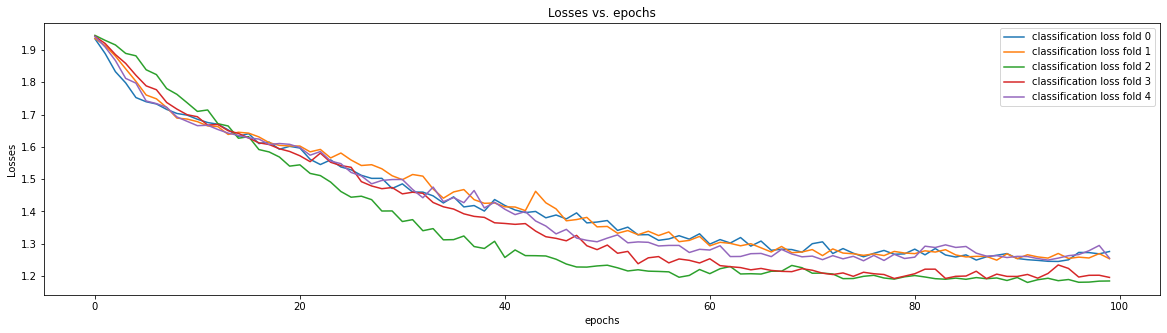

In [19]:
plt.figure(figsize=(20,5))
plt.title('Losses vs. epochs')
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.plot(range(EPOCHS), fold_emotion_class_losses[0],label='classification loss fold 0')
plt.plot(range(EPOCHS), fold_emotion_class_losses[1],label='classification loss fold 1')
plt.plot(range(EPOCHS), fold_emotion_class_losses[2],label='classification loss fold 2')
plt.plot(range(EPOCHS), fold_emotion_class_losses[3],label='classification loss fold 3')
plt.plot(range(EPOCHS), fold_emotion_class_losses[4],label='classification loss fold 4')
plt.legend(loc='best')
plt.show() 

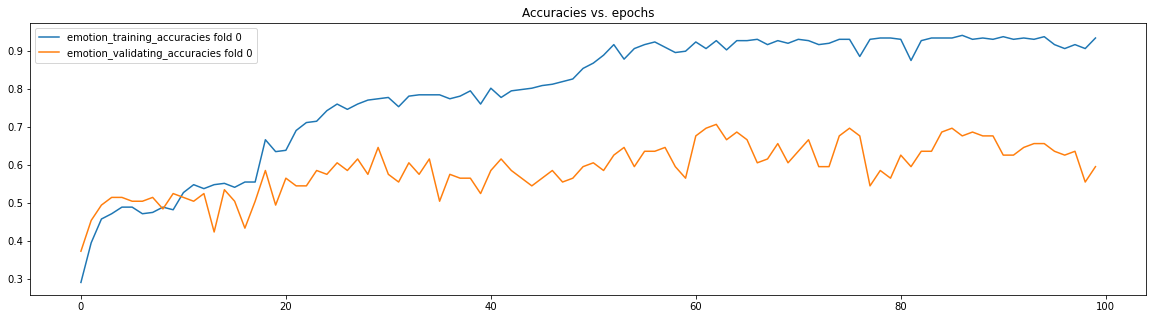

Maximum emotion training accuracy:94.10%
Maximum emotion validating accuracy:70.71%


In [20]:
plt.figure(figsize=(20,5))
plt.title('Accuracies vs. epochs')
plt.plot(range(EPOCHS), fold_emotion_training_accuracies[0],label='emotion_training_accuracies fold 0')
plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[0],label='emotion_validating_accuracies fold 0')
plt.legend(loc='best')
plt.show() 
print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[0])*100))
print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[0])*100))

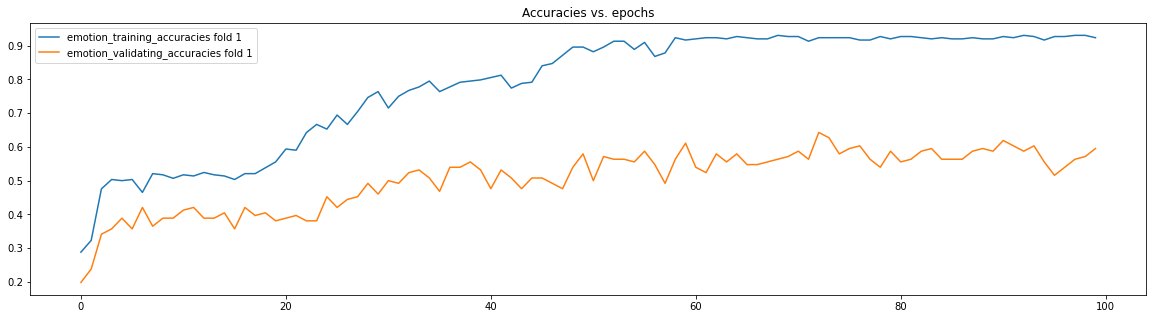

Maximum emotion training accuracy:93.06%
Maximum emotion validating accuracy:64.29%


In [21]:
plt.figure(figsize=(20,5))
plt.title('Accuracies vs. epochs')
plt.plot(range(EPOCHS), fold_emotion_training_accuracies[1],label='emotion_training_accuracies fold 1')
plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[1],label='emotion_validating_accuracies fold 1')
plt.legend(loc='best')
plt.show() 
print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[1])*100))
print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[1])*100))

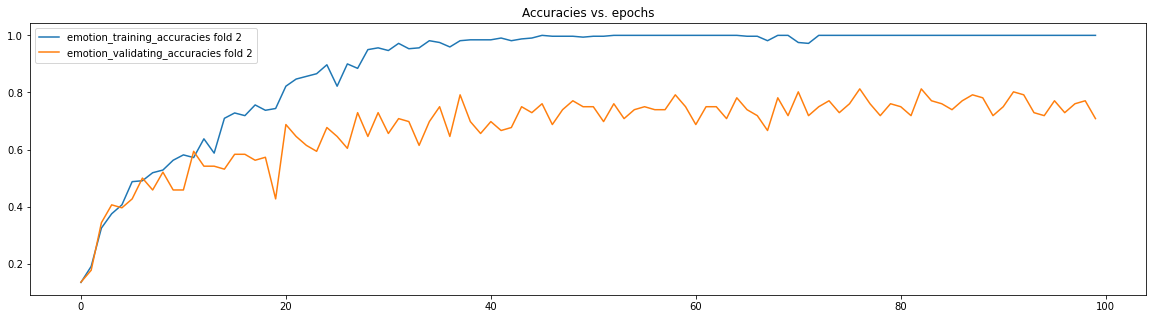

Maximum emotion training accuracy:100.00%
Maximum emotion validating accuracy:81.25%


In [22]:
plt.figure(figsize=(20,5))
plt.title('Accuracies vs. epochs')
plt.plot(range(EPOCHS), fold_emotion_training_accuracies[2],label='emotion_training_accuracies fold 2')
plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[2],label='emotion_validating_accuracies fold 2')
plt.legend(loc='best')
plt.show() 
print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[2])*100))
print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[2])*100))

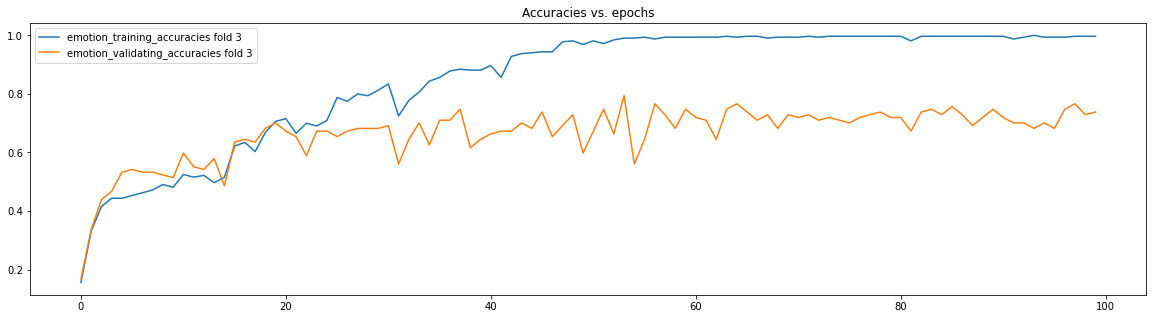

Maximum emotion training accuracy:100.00%
Maximum emotion validating accuracy:79.44%


In [23]:
plt.figure(figsize=(20,5))
plt.title('Accuracies vs. epochs')
plt.plot(range(EPOCHS), fold_emotion_training_accuracies[3],label='emotion_training_accuracies fold 3')
plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[3],label='emotion_validating_accuracies fold 3')
plt.legend(loc='best')
plt.show() 
print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[3])*100))
print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[3])*100))

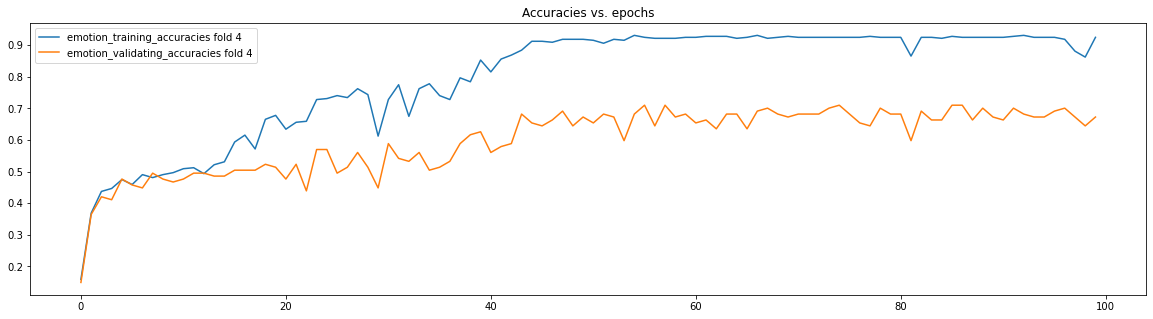

Maximum emotion training accuracy:93.12%
Maximum emotion validating accuracy:71.03%


In [24]:
plt.figure(figsize=(20,5))
plt.title('Accuracies vs. epochs')
plt.plot(range(EPOCHS), fold_emotion_training_accuracies[4],label='emotion_training_accuracies fold 4')
plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[4],label='emotion_validating_accuracies fold 4')
plt.legend(loc='best')
plt.show() 
print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[4])*100))
print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[4])*100))

## 5. Loading and evaluating the model

In [25]:
from statistics import mean , stdev

lfold_emotion_training_accuracies, lfold_emotion_validating_accuracies, lfold_emotion_testing_accuracies = [] , [] , []

for fold in range(5):
    print("\nEvaluation for fold {}".format(fold))
    checkpoint = torch.load(MODEL_PATH + 'fold' + str(fold))
    
    DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    #speaker_classifier = SpeakerClassifier().to(DEVICE)

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    #speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    emotion_classifier.load_state_dict(checkpoint['emotion_classifier_state_dict'])
    #speaker_classifier.load_state_dict(checkpoint['speaker_classifier_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    emotion_optimizer.load_state_dict(checkpoint['emotion_optimizer_state_dict'])
    #speaker_optimizer.load_state_dict(checkpoint['speaker_optimizer_state_dict'])
    
    emodb_dataset_train = EmoDBDataset2('./Dataset/emodb',cv_index = fold ,split= 'train')
    emodb_dataset_test = EmoDBDataset2('./Dataset/emodb',cv_index = fold, split= 'test')
    emodb_dataset_validate = EmoDBDataset2('./Dataset/emodb',cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = len(emodb_dataset_train)
    VALIDATE_BATCH_SIZE = len(emodb_dataset_validate)
    TEST_BATCH_SIZE = len(emodb_dataset_test)
    
    emodb_train_loader = DataLoader(dataset=emodb_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    emodb_validate_loader = DataLoader(dataset=emodb_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    emodb_test_loader = DataLoader(dataset=emodb_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    
    encoder.eval()
    emotion_classifier.eval()

    lemotion_training_correct, lemotion_validating_correct, lemotion_testing_correct = 0 , 0 , 0

    with torch.no_grad():

        # 1. Training Classification
        for index, (waveform, sample_rate, emotion, speaker) in enumerate(emodb_train_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            lemotion_training_correct += (emotion_preds == emotion).sum() 
        emotion_training_accuracy = lemotion_training_correct.item()/(len(emodb_train_loader)*TRAIN_BATCH_SIZE)
        print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(lemotion_training_correct,(len(emodb_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))

        # 2. Validating Classification
        for index, (waveform, sample_rate, emotion, speaker) in enumerate(emodb_validate_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            lemotion_validating_correct += (emotion_preds == emotion).sum() 
        emotion_validating_accuracy = lemotion_validating_correct.item()/(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE)
        print("Emotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(lemotion_validating_correct,(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))        


        # 3. Testing Classification
        for index, (waveform, sample_rate, emotion, speaker) in enumerate(emodb_test_loader):
            waveform, emotion = waveform.to(DEVICE),emotion.to(DEVICE) 
            mfcc_features = MFCC_Extractor(waveform , DEVICE)
            mfcc_conv_features = encoder(mfcc_features)
            emotion_output = emotion_classifier(mfcc_conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            lemotion_testing_correct += (emotion_preds == emotion).sum() 
        emotion_testing_accuracy = lemotion_testing_correct.item()/(len(emodb_test_loader)*TEST_BATCH_SIZE)
        print("Emotion Testing Correct: {}/{} \nEmotion Testing Accuracy: {:.5f}%".format(lemotion_testing_correct,(len(emodb_test_loader)*TEST_BATCH_SIZE),emotion_testing_accuracy*100))
        
        lfold_emotion_training_accuracies.append(emotion_training_accuracy)
        lfold_emotion_validating_accuracies.append(emotion_validating_accuracy)
        lfold_emotion_testing_accuracies.append(emotion_testing_accuracy)
    

print('\nSUMMARY:')
print('\nCV Emotion Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_training_accuracies), stdev(lfold_emotion_training_accuracies)))
print('\nCV Emotion Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_validating_accuracies), stdev(lfold_emotion_validating_accuracies)))
print('\nCV Emotion Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_testing_accuracies), stdev(lfold_emotion_testing_accuracies)))



Evaluation for fold 0


/home/bryanleow/FYP/lib/python3.7/site-packages/scipy/signal/signaltools.py:1475: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/bryanleow/FYP/lib/python3.7/site-packages/scipy/signal/signaltools.py:1475: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/bryanleow/FYP/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Emotion Training Correct: 284/310 
Emotion Training Accuracy: 91.61290%
Emotion Validating Correct: 70/99 
Emotion Validating Accuracy: 70.70707%
Emotion Testing Correct: 72/126 
Emotion Testing Accuracy: 57.14286%

Evaluation for fold 1
Emotion Training Correct: 289/313 
Emotion Training Accuracy: 92.33227%
Emotion Validating Correct: 81/126 
Emotion Validating Accuracy: 64.28571%
Emotion Testing Correct: 65/96 
Emotion Testing Accuracy: 67.70833%

Evaluation for fold 2
Emotion Training Correct: 332/332 
Emotion Training Accuracy: 100.00000%
Emotion Validating Correct: 78/96 
Emotion Validating Accuracy: 81.25000%
Emotion Testing Correct: 87/107 
Emotion Testing Accuracy: 81.30841%

Evaluation for fold 3
Emotion Training Correct: 318/321 
Emotion Training Accuracy: 99.06542%
Emotion Validating Correct: 85/107 
Emotion Validating Accuracy: 79.43925%
Emotion Testing Correct: 79/107 
Emotion Testing Accuracy: 73.83178%

Evaluation for fold 4
Emotion Training Correct: 305/329 
Emotion Tra